# 4DHumans Demo Notebook
This a demo notebook for our paper "4DHumans: Reconstructing and Tracking Humans with Transformers".

<p align="left"><img src="https://github.com/shubham-goel/4D-Humans/raw/main/assets/teaser.png" width="800"></p>

<p align="left"><img src="https://github.com/brjathu/PHALP/raw/master/assets/imgs/teaser.gif" width="800"></p>

Project webpage: https://shubham-goel.github.io/4dhumans/

Github repo: https://github.com/shubham-goel/4D-Humans

Instructions:

1. Enable the GPU Runtime (Runtime > Change Runtime Type > GPU)
2. Clone the repository and install depencencies
3. Run the demo
4. Visualize the video


# Clone the repository and install dependencies

In [ ]:
# Clone the main repo
%%capture
! git clone https://github.com/shubham-goel/4D-Humans.git 4D-Humans
%cd 4D-Humans

In [ ]:
!pip install torch
!pip install -e .[all]
!wget https://github.com/classner/up/raw/master/models/3D/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl
!mkdir data/
!mv basicModel_neutral_lbs_10_207_0_v1.0.0.pkl data/

# Run the demo

In [ ]:
# run hmr2 on a folder of images
!python demo.py \
--img_folder example_data/images \
--out_folder demo_out \
--batch_size=48 --side_view --save_mesh

### Visualize the reconstructions

In [ ]:
from IPython.display import Image, display
import os
# https://colab.research.google.com/drive/1Ex4gE5v1bPR3evfhtG7sDHxQGsWwNwby?usp=sharing
output_images = ["demo_out/" + i for i in os.listdir("demo_out/") if ".png" in i]
for img in output_images:
  display(Image(img))



# Video Demo

### Install PHALP

In [ ]:
!pip install git+https://github.com/brjathu/PHALP.git

### Track and visualize

In [ ]:
!python track.py video.source="example_data/videos/gymnasts.mp4" video.start_frame=10 video.end_frame=60

In [1]:
# Display the reconstruction video
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                      <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

!ffmpeg -y -hide_banner -loglevel error -i outputs/PHALP_gymnasts.mp4 outputs/PHALP_gymnasts_ffmpeg.mp4
show_local_mp4_video('outputs/PHALP_gymnasts_ffmpeg.mp4', width=960, height=540)

^C


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/PHALP_gymnasts_ffmpeg.mp4'

# Visualize with Polyscope

In [1]:
import pickle as pkl
import gzip
# joblib is used to load the model outputs
import joblib
import polyscope as ps
import polyscope.imgui as psim
from matplotlib import pyplot as plt
import os, sys
import numpy as np
import cv2
from scipy.interpolate import interp1d
from scipy.spatial.transform import Slerp
from scipy.spatial.transform import Rotation as R

sys.path.insert(0, os.path.abspath("/scratch/ondemand27/evanpan/motion_instruction/smpl"))
sys.path.insert(0, os.path.abspath("/Users/evanpan/Documents/GitHub/Motion_instruction/smpl"))
from smpl_np import SMPLModel
# from smpl.smpl_webuser.serialization import load_model
# from phalp.utils import smpl_utils

In [2]:
# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 1

In [3]:

motionData_path = "./4D-Humans_outputs/results/demo_biggerspin1.pkl"
motiondata = joblib.load(open(motionData_path, "rb"))
# load smpl model
smpl = SMPLModel('./smpl/models/model.pkl')

## Load time-varying parameters

In [4]:
def load_motion_data(motionData_path, main_guy):
    # load motion data
    motiondata = joblib.load(open(motionData_path, "rb"))
    frames = sorted(list(motiondata.keys()))
    per_frame_smpl_data = {"time":[], "beta":[], "pose":[], "position":[]}
    for i in range(0, len(frames)):
        frame_i = motiondata[frames[i]]
        # print(frame_i.keys())
        pose_i = frame_i["pose"] # this stores a list of poses for characters in the 
        center_i = frame_i["center"]
        scale_i = frame_i["scale"]
        smpl_i = frame_i["smpl"]
        ids_i = frame_i['tid']
        threeD_joints_i = frame_i['3d_joints']
        # only care about the guy of interest
        # print(ids_i)
        if main_guy not in ids_i:
            continue
        pose_i_main = pose_i[ids_i.index(main_guy)]
        threeD_joints_i_main = threeD_joints_i[ids_i.index(main_guy)] # shape is (43, 3)
        smpl_i_main = smpl_i[ids_i.index(main_guy)] # dictionary with keys ['global_orient', 'body_pose', 'betas']
        # get the smpl parameters
        global_orient = smpl_i_main["global_orient"] # defined root orentation (rotation matrix )
        body_pose = smpl_i_main["body_pose"] # defines the rotation matrix of the 23 joints (generated using Rodrigues formula)
        beta = smpl_i_main["betas"] # shape is (10,)
        # convert rotation matrices in body pose to axis-angle representation
        body_pose_aa = np.zeros((body_pose.shape[0], 3))
        for jj in range(body_pose.shape[0]):
            body_pose_aa[jj] = cv2.Rodrigues(body_pose[jj])[0].squeeze()
        # rotate global_orient by 180 degrees by x axis
        # global_orient[0] = cv2.Rodrigues(np.array([np.pi, 0, 0]))[0].squeeze() @ global_orient[0]
        global_orient_aa = np.array([cv2.Rodrigues(global_orient[0])[0].squeeze()])
        # check for discontinuities in the global orientation
        if global_orient_aa[0, 0] < 0:
            global_orient_aa *= -1
                    
        #             global_orient_aa[0][jj] *= -1
        # global_orient_aa[np.where(global_orient_aa > np.pi)] -= 2*np.pi
        # global_orient_aa[np.where(global_orient_aa < -np.pi)] += 2*np.pi
        body_pose_aa = np.concatenate([global_orient_aa, body_pose_aa], axis=0)
        # load data related to smpl model
        per_frame_smpl_data["time"].append(frame_i["time"])
        per_frame_smpl_data["beta"].append(beta)
        per_frame_smpl_data["pose"].append(body_pose_aa)
        per_frame_smpl_data["position"].append(np.zeros([3, ]))
    per_frame_smpl_data["beta"] = np.array(per_frame_smpl_data["beta"])
    per_frame_smpl_data["pose"] = np.array(per_frame_smpl_data["pose"])
    per_frame_smpl_data["position"] = np.array(per_frame_smpl_data["position"])
    per_frame_smpl_data["time"] = np.array(per_frame_smpl_data["time"])

    per_frame_smpl_data["pose_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["pose"], axis=0, fill_value="extrapolate", bounds_error=False, kind="linear")
    
    per_frame_smpl_data["beta_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["beta"], axis=0, fill_value="extrapolate", bounds_error=False)
    per_frame_smpl_data["position_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["position"], axis=0, fill_value="extrapolate", bounds_error=False)
    return per_frame_smpl_data
    # print(per_frame_smpl_data["beta"].shape, per_frame_smpl_data["pose"].shape, per_frame_smpl_data["position"].shape)


## Visualize detected mesh

In [7]:
class SlerpInterpolationMultiObject:
    def __init__(self, timestamps, rotation_vectors):
        """
        Initialize with timestamps and rotation vectors.   
        :param timestamps: Array of shape [T], where T is the number of timestamps.
        :param rotation_vectors: Array of shape [T, N, 3], where N is the number of objects,
                                 and each rotation vector is 3D.
        """
        self.timestamps = np.array(timestamps)
        self.rotations = []
        self.rotations_interps = []
        for i in range(0, rotation_vectors.shape[1]):
            self.rotations.append(R.from_rotvec(rotation_vectors[:, i]))
        for i in range(0, len(self.rotations)):
            self.rotations_interps.append(Slerp(self.timestamps, self.rotations[i]))
        self.num_objects = rotation_vectors.shape[1]
    def __call__(self, target_time):
        """
        Interpolate rotation vectors for each object at specified target times.
        
        :param target_times: Array of target times for interpolation.
        :return: Interpolated rotation vectors of shape [len(target_times), N, 3].
        """ 
        # target_times = np.atleast_1d(target_times)
        interpolated_rotations = []
        for i in range(0, len(self.rotations_interps)):
            interpolated_rotations.append(self.rotations_interps[i](target_time).as_rotvec())
        return np.array(interpolated_rotations)
def load_motion_data_slerp(motionData_path, main_guy):
    # load motion data
    motiondata = joblib.load(open(motionData_path, "rb"))
    frames = sorted(list(motiondata.keys()))
    per_frame_smpl_data = {"time":[], "beta":[], "pose":[], "position":[], "camera":[], "root_position":[]}
    for i in range(0, len(frames)):
        frame_i = motiondata[frames[i]]
        pose_i = frame_i["pose"] # this stores a list of poses for characters in the 
        center_i = frame_i["center"]
        scale_i = frame_i["scale"]
        smpl_i = frame_i["smpl"]
        ids_i = frame_i['tid']
        threeD_joints_i = frame_i['3d_joints']
        camera_i = frame_i['camera']
        # only care about the guy of interest
        # print(ids_i)
        if main_guy not in ids_i:
            continue
        pose_i_main = pose_i[ids_i.index(main_guy)]
        threeD_joints_i_main = threeD_joints_i[ids_i.index(main_guy)] # shape is (43, 3)
        smpl_i_main = smpl_i[ids_i.index(main_guy)] # dictionary with keys ['global_orient', 'body_pose', 'betas']
        camera_i_main = camera_i[ids_i.index(main_guy)]
        # get the smpl parameters
        global_orient = smpl_i_main["global_orient"] # defined root orentation (rotation matrix )
        body_pose = smpl_i_main["body_pose"] # defines the rotation matrix of the 23 joints (generated using Rodrigues formula)
        beta = smpl_i_main["betas"] # shape is (10,)
        # convert rotation matrices in body pose to axis-angle representation
        body_pose_aa = np.zeros((body_pose.shape[0], 3))
        for jj in range(body_pose.shape[0]):
            body_pose_aa[jj] = cv2.Rodrigues(body_pose[jj])[0].squeeze()
        # rotate global_orient by 180 degrees by x axis
        # global_orient[0] = cv2.Rodrigues(np.array([np.pi, 0, 0]))[0].squeeze() @ global_orient[0]
        global_orient_aa = np.array([cv2.Rodrigues(global_orient[0])[0].squeeze()])
        # check for discontinuities in the global orientation
        if global_orient_aa[0, 0] < 0:
            global_orient_aa *= -1
                    
        #             global_orient_aa[0][jj] *= -1
        # global_orient_aa[np.where(global_orient_aa > np.pi)] -= 2*np.pi
        # global_orient_aa[np.where(global_orient_aa < -np.pi)] += 2*np.pi
        body_pose_aa = np.concatenate([global_orient_aa, body_pose_aa], axis=0)
        # load data related to smpl model
        per_frame_smpl_data["time"].append(frame_i["time"])
        per_frame_smpl_data["beta"].append(beta)
        per_frame_smpl_data["pose"].append(body_pose_aa)
        per_frame_smpl_data["position"].append(np.zeros([3, ]))
        per_frame_smpl_data["camera"].append(camera_i_main)
        per_frame_smpl_data["root_position"].append(threeD_joints_i_main[0])
        
    per_frame_smpl_data["beta"] = np.array(per_frame_smpl_data["beta"])
    per_frame_smpl_data["pose"] = np.array(per_frame_smpl_data["pose"])
    per_frame_smpl_data["position"] = np.array(per_frame_smpl_data["position"])
    per_frame_smpl_data["time"] = np.array(per_frame_smpl_data["time"])
    per_frame_smpl_data["camera"] = np.array(per_frame_smpl_data["camera"])
    per_frame_smpl_data["camera"] = per_frame_smpl_data["camera"] - per_frame_smpl_data["camera"][0:1]
    per_frame_smpl_data["camera"] *= 1/100
    per_frame_smpl_data["root_position"] = np.array(per_frame_smpl_data["root_position"])
    per_frame_smpl_data["root_position"] -= per_frame_smpl_data["root_position"][0:1]

    per_frame_smpl_data["pose_interp"] = SlerpInterpolationMultiObject(per_frame_smpl_data["time"], per_frame_smpl_data["pose"])
    per_frame_smpl_data["beta_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["beta"], axis=0, fill_value="extrapolate", bounds_error=False)
    per_frame_smpl_data["position_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["position"], axis=0, fill_value="extrapolate", bounds_error=False)
    per_frame_smpl_data["camera_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["camera"], axis=0, fill_value="extrapolate", bounds_error=False)
    per_frame_smpl_data["root_position_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["root_position"], axis=0, fill_value="extrapolate", bounds_error=False)
    return per_frame_smpl_data
# inputs
motionData_path = "./4D-Humans_outputs/results/demo_truck_stand12.pkl"
main_guy = 1
motion_data_1 = load_motion_data_slerp(motionData_path, 1)
motion_data_2 = load_motion_data_slerp(motionData_path, 2)
    # print(per_frame_smpl_data["beta"].shape, per_frame_smpl_data["pose"].shape, per_frame_smpl_data["position"].shape)

(24, 3)


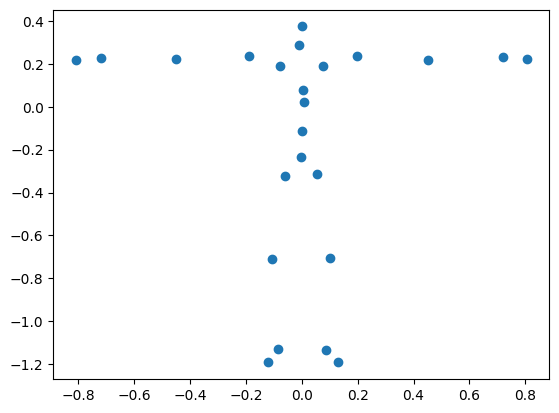

In [18]:
print(smpl.J.shape)
plt.plot(smpl.J[:, 0], smpl.J[:, 1], 'o')

In [8]:
def update_mesh():
    global mesh_list, params_list, simulator_t
    for i in range(0, len(mesh_list)):
        beta = params_list[i]["beta_interp"](simulator_t)
        pose = params_list[i]["pose_interp"](simulator_t)
        position = params_list[i]["position_interp"](simulator_t)
        smpl.set_params(beta=beta, pose=pose, trans=position)
        translated_verts = smpl.verts
        translated_verts[:, 1] += np.expand_dims(params_list[i]["root_position_interp"](simulator_t), axis=0)[:, 1]
        mesh_list[i].update_vertex_positions(translated_verts)
# SM1.update_vertex_positions(V1)
def guii():
    global simulator_t, simulator_to_end_t
    # psim.TextUnformatted("Some sample text")
    time_changed, simulator_t = psim.SliderFloat("time", simulator_t, v_min=0, v_max=simulator_to_end_t)
    if time_changed:
        update_mesh()
params_list = [motion_data_1, motion_data_2]
mesh_list = []
ps.set_verbosity(0)
ps.set_SSAA_factor(4)
ps.set_program_name("Interactive Viewer")
ps.set_ground_plane_mode("none")
ps.set_view_projection_mode("orthographic")
ps.set_autocenter_structures(False)
ps.set_autoscale_structures(False)
ps.set_front_dir("z_front")
ps.set_up_dir("neg_y_up")
ps.set_background_color([0, 0, 0])
ps.init()
simulator_t = 0
simulator_to_end_t = params_list[0]["time"][-1]
# iterate through each clip to create the mesh + load the parameters
for i in range(0, len(params_list)):
    params = params_list[i]
    smpl.set_params(beta=params["beta"][0], pose=params["pose"][0], trans=params["position"][0])
    mesh_list.append(ps.register_surface_mesh("mesh_{}".format(i), smpl.verts, smpl.faces, color=[0.9,0.9,0.9], smooth_shade=True, edge_width=0.25, ))

ps.set_user_callback(guii)
ps.show()